# Bank Churn Preprocessing and Feature Engineering

In [1]:
#import requisite libraries

#data analysis
import pandas as pd
import numpy as np

#data visualization
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

#feature engineering
from sklearn.preprocessing import OneHotEncoder

#feature scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

Import dataset for preprocessing

In [2]:
#load data
df = pd.read_csv('Cleaned_Df.csv')

df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Preprocessing Overview

With the goal of building two model with different objectives, I plan to preprocess the data in multiple formats:

* Inferential - Draw cause of current state of churn from raw data
    * No feature creation
    * Minimal scaling to enable LogisticRegression convergance
* Perdictive - In the stack alert to customers/revenue at risk of churning
    * Feature Creation as needed
    
To begin, I'll tackle the basic encoding for the inferential model

In [3]:
#Gender is a binary response in our data so can simply transform the column
fe_df = df.copy()

fe_df['Gender'] = fe_df['Gender'].apply(lambda x : 0 if x == 'Male' else 1)

#since Geography has three unique responses, I'll use Scikit-Learn's OneHotEncoding to create the necessary binary activation of the Geography parameter

#get array of Geography values
geo = fe_df.Geography.values

ohe = OneHotEncoder(categories='auto',sparse=False)
geo_ohe = ohe.fit_transform(geo.reshape(-1,1))

geo_df = pd.DataFrame(geo_ohe, columns=[name[3:] for name in ohe.get_feature_names()])
geo_df.head()

,France,Germany,Spain
0,1.0,0.0,0.0
1,0.0,0.0,1.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,0.0,0.0,1.0


In [4]:
#add the preproccessed columns back to dataset

fe_df = pd.concat([fe_df,geo_df],axis=1,join='inner')

#reorder and drop duplicate column
cols = list(fe_df.columns.values)
cols.pop(cols.index('Geography'))
cols.pop(cols.index('Exited'))

fe_df = fe_df[cols+['Exited']]


#export for tree modeling
fe_df.to_csv('simple_preprocessed_unscaled_df.csv', index=False)
fe_df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,France,Germany,Spain,Exited
0,619,1,42,2,0.00,1,1,1,101348.88,1.0,0.0,0.0,1
1,608,1,41,1,83807.86,1,0,1,112542.58,0.0,0.0,1.0,0
2,502,1,42,8,159660.80,3,1,0,113931.57,1.0,0.0,0.0,1
3,699,1,39,1,0.00,2,0,0,93826.63,1.0,0.0,0.0,0
4,850,1,43,2,125510.82,1,1,1,79084.10,0.0,0.0,1.0,0


## Skewed Distributions
As explored in the EDA notebook, the distribution for the Age variable has a right hand skew (right hand tail). In order provide a more normal data distribution, I will apply the natural log transform to the data.

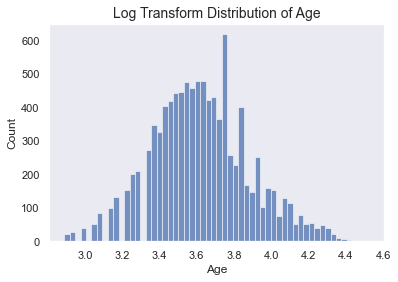

In [5]:
#copy to preserve original dataset within notebook
fe_scaled_df = fe_df.copy()
sns.set_theme(style="darkgrid")
fe_scaled_df.Age = np.log(fe_scaled_df.Age)

fig, ax = plt.subplots(figsize=(6,4))
sns.histplot(fe_scaled_df.Age)
plt.grid(False)
plt.title('Log Transform Distribution of Age', size=14);

### Multicollinarty

As explored in the EDA notebook, our features exhibited varying degrees of collinarity that would compromise the modeling exercise and insights gleaned within. To prevent this we will scale the affected columns by their respected means in order to break the existing cross feature collinarity.

In [6]:
#reduce Collinear features by respected means
fe_scaled_df.CreditScore = fe_scaled_df.CreditScore - fe_scaled_df.CreditScore.mean()
fe_scaled_df.Age = fe_scaled_df.Age - fe_scaled_df.Age.mean()
fe_scaled_df.NumOfProducts = fe_scaled_df.NumOfProducts - fe_scaled_df.NumOfProducts.mean()

Check updated VIF

In [7]:
vif = pd.DataFrame()
cont_df = fe_scaled_df#.drop(['Geography','Gender'], axis=1)
vif["VIF Factor"] = [variance_inflation_factor(cont_df.values, i) for i in range(cont_df.shape[1])]
vif['Features'] = cont_df.columns
vif

,VIF Factor,Features
0,1.001643,CreditScore
1,1.013217,Gender
2,1.110828,Age
3,1.002165,Tenure
4,1.339195,Balance
5,1.122924,NumOfProducts
6,1.001619,HasCrCard
7,1.041229,IsActiveMember
8,1.001036,EstimatedSalary
9,7.096556,France


In [8]:
fe_scaled_df.to_csv('simple_preprocessed_scaled_df.csv', index=False)

The data is now amended and should be stable during the linear modeling process.

Now that the basic data is preprocessed I'll save it as 'simple_preproccessed_df'.csv for the first modeling task

### Preprocessing - Feature Generation - Prediction Modeling

For our second task of creating an in the stack alert for predicting Customer Churn, we will feature engineer novel interactions between the given parameters in order to create additional datapoints for our models to access.

In [9]:

tenure_age_ratio = fe_df.Tenure/fe_df.Age

credit_age_ratio = fe_df.CreditScore/fe_df.Age

bal_is_zero = fe_df.Balance.apply(lambda x : 1 if x==0 else 0)

bal_sal_ratio = fe_df.Balance/fe_df.EstimatedSalary

In [10]:
fe_df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,France,Germany,Spain,Exited
0,619,1,42,2,0.00,1,1,1,101348.88,1.0,0.0,0.0,1
1,608,1,41,1,83807.86,1,0,1,112542.58,0.0,0.0,1.0,0
2,502,1,42,8,159660.80,3,1,0,113931.57,1.0,0.0,0.0,1
3,699,1,39,1,0.00,2,0,0,93826.63,1.0,0.0,0.0,0
4,850,1,43,2,125510.82,1,1,1,79084.10,0.0,0.0,1.0,0


In [11]:
fe_df.insert(4, 'Tenure_Age_ratio', tenure_age_ratio)
fe_df.insert(1, 'Credit_Age_ratio', credit_age_ratio)
fe_df.insert(7, 'Bal_is_zero', bal_is_zero)
fe_df.insert(12, 'Balance_Salary_ratio', bal_sal_ratio)

In [12]:
fe_df.head()

,CreditScore,Credit_Age_ratio,Gender,Age,Tenure,Tenure_Age_ratio,Balance,Bal_is_zero,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Balance_Salary_ratio,France,Germany,Spain,Exited
0,619,14.738095,1,42,2,0.047619,0.00,1,1,1,1,101348.88,0.000000,1.0,0.0,0.0,1
1,608,14.829268,1,41,1,0.024390,83807.86,0,1,0,1,112542.58,0.744677,0.0,0.0,1.0,0
2,502,11.952381,1,42,8,0.190476,159660.80,0,3,1,0,113931.57,1.401375,1.0,0.0,0.0,1
3,699,17.923077,1,39,1,0.025641,0.00,1,2,0,0,93826.63,0.000000,1.0,0.0,0.0,0
4,850,19.767442,1,43,2,0.046512,125510.82,0,1,1,1,79084.10,1.587055,0.0,0.0,1.0,0


In [13]:
fe_df.to_csv('feature_engineered_df.csv', index=False)